In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
df = pd.read_csv('dataset/cars.csv')

# Drop rows with missing values in target variable
df = df.dropna(subset=['price_usd'])

# Separate features and target
y = df['price_usd']

# Select numeric features
numeric_features = ['manufacture_year', 'engine_cc', 'horsepower', 'mileage_km_per_l']

# Select categorical features
categorical_features = ['brand', 'body_type', 'fuel_type', 'transmission', 'manufacturing_country']

# One-hot encode categorical features
df_encoded = pd.get_dummies(df[categorical_features], drop_first=True, dtype=float)

# Combine numeric and encoded categorical features
X = pd.concat([df[numeric_features], df_encoded], axis=1)

# Remove rows with any missing values
complete_mask = ~(X.isna().any(axis=1))
X = X[complete_mask]
y = y[complete_mask]

print(f"Dataset size: {len(y)} samples")
print(f"Total number of features: {len(X.columns)}")
print(f"  - Numeric features: {len(numeric_features)}")
print(f"  - Encoded categorical features: {len(df_encoded.columns)}")
print(f"\nFeature columns: {list(X.columns[:10])}... (showing first 10)")

Dataset size: 300 samples
Total number of features: 26
  - Numeric features: 4
  - Encoded categorical features: 22

Feature columns: ['manufacture_year', 'engine_cc', 'horsepower', 'mileage_km_per_l', 'brand_BMW', 'brand_Ford', 'brand_Honda', 'brand_Hyundai', 'brand_Kia', 'brand_Mercedes']... (showing first 10)


In [57]:
# Feature scaling
X_original = X.copy()  # Keep original for coefficient interpretation
X_max = X.max()
y_max = y.max()

X = X / X_max
X = X.values

y = y / y_max
y = y.values.reshape(-1, 1)

In [58]:
# Train-Test Split (80-20 split)
np.random.seed(42)  # For reproducibility
n_samples = len(y)
indices = np.arange(n_samples)
np.random.shuffle(indices)

# Calculate split point
train_size = int(0.8 * n_samples)

# Split indices
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Split the data
X_train = X[train_indices]
X_test = X[test_indices]
y_train = y[train_indices]
y_test = y[test_indices]

print(f"Total samples: {n_samples}")
print(f"Training samples: {len(X_train)} ({len(X_train)/n_samples*100:.1f}%)")
print(f"Test samples: {len(X_test)} ({len(X_test)/n_samples*100:.1f}%)")

Total samples: 300
Training samples: 240 (80.0%)
Test samples: 60 (20.0%)


In [59]:
# Adding 1's column for intercept
X_train = np.c_[np.ones(len(X_train)), X_train]
X_test = np.c_[np.ones(len(X_test)), X_test]

print(f"X_train shape after adding intercept: {X_train.shape}")
print(f"X_test shape after adding intercept: {X_test.shape}")
print(f"First 5 rows of X_train (showing first 5 columns):\n{X_train[:5, :5]}")

# Initialize theta - 1 intercept + all features
n_features = X_train.shape[1]
theta = np.zeros((n_features, 1))
print(f"\nInitialized theta with {n_features} parameters")

X_train shape after adding intercept: (240, 27)
X_test shape after adding intercept: (60, 27)
First 5 rows of X_train (showing first 5 columns):
[[1.         1.         0.66019223 0.35392321 0.8       ]
 [1.         0.99753086 0.48518222 0.34223706 0.8       ]
 [1.         0.99209877 0.81317581 0.27378965 0.33333333]
 [1.         0.99753086 0.85182219 0.19365609 0.56666667]
 [1.         0.99703704 0.40128154 0.40901503 0.53333333]]

Initialized theta with 27 parameters


In [60]:
# Gradient descent (training on training set only)
epochs = 10000
learning_rate = 0.01
m = len(y_train)
costs = []

for i in range(epochs):
    h = X_train @ theta
    error = h - y_train
    cost = (1/(2*m)) * np.sum(np.square(error))
    costs.append(cost)
    
    gradient = (1/m) * (X_train.T @ error)
    theta = theta - learning_rate * gradient

print(f"Final theta: {theta.flatten()}")

Final theta: [ 0.21023054  0.2090793  -0.06195693  0.16724847  0.0170033  -0.01381857
  0.05418824 -0.00716537  0.03459192  0.07483237  0.13444765  0.03247922
 -0.01310849  0.069626    0.02667393  0.07676381 -0.01687071 -0.01926711
 -0.05367665  0.03151459 -0.03250134  0.02067417 -0.03354181 -0.03347078
  0.08162321 -0.01277122 -0.02024591]


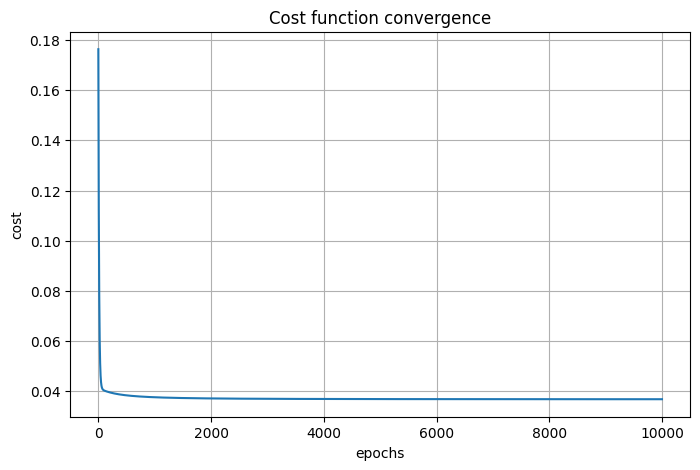

In [61]:
# Cost convergence plot
plt.figure(figsize=(8,5))
plt.plot(range(epochs), costs)
plt.title('Cost function convergence')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.grid(True)
plt.show()

In [62]:
# Interpret coefficients (converting back to original scale)
intercept_original = y_max * theta[0].item()

# Get feature names (excluding the intercept column)
feature_names = ['intercept'] + list(X_original.columns)

# Calculate original scale coefficients
coefficients = {}
coefficients['intercept'] = intercept_original

for i, col in enumerate(X_original.columns):
    if col in ['manufacture_year', 'engine_cc', 'horsepower', 'mileage_km_per_l']:
        # Numeric features need to be un-scaled
        coefficients[col] = (y_max * theta[i+1].item()) / X_max[col]
    else:
        # One-hot encoded features (already 0 or 1, no scaling applied)
        coefficients[col] = y_max * theta[i+1].item()

# Create a sorted list of coefficients by absolute value
coef_df = pd.DataFrame(list(coefficients.items()), columns=['Feature', 'Coefficient'])
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print("\nMODEL COEFFICIENTS:")
print(f"Intercept: ${intercept_original:,.2f}\n")

print("TOP 10 MOST INFLUENTIAL FEATURES (by absolute coefficient value):")
for idx, row in coef_df.head(11).iterrows():  # 11 to include intercept
    if row['Feature'] != 'intercept':
        print(f"{row['Feature']:40s}: ${row['Coefficient']:>12,.4f}")

print(f"\n... and {len(coef_df) - 11} more features")


MODEL COEFFICIENTS:
Intercept: $25,140.84

TOP 10 MOST INFLUENTIAL FEATURES (by absolute coefficient value):
brand_Mercedes                          : $ 16,078.1910
manufacturing_country_South Korea       : $  9,761.0744
body_type_Pickup                        : $  9,179.9542
brand_Kia                               : $  8,948.9788
brand_Toyota                            : $  8,326.3642
brand_Ford                              : $  6,480.2095
fuel_type_Electric                      : $ -6,419.0300
brand_Hyundai                           : $  4,136.7434
manufacturing_country_Germany           : $ -4,011.1642
manufacturing_country_Japan             : $ -4,002.6701

... and 16 more features


In [63]:
# Evaluation: MSE, RMSE, R² on both training and test sets

# Training set evaluation
y_pred_train = (X_train @ theta) * y_max
y_actual_train = y_train * y_max

mse_train = (1/len(y_train)) * np.sum(np.square(y_actual_train - y_pred_train))
rmse_train = np.sqrt(mse_train)

y_mean_train = np.mean(y_actual_train)
ss_res_train = np.sum(np.square(y_actual_train - y_pred_train))
ss_tot_train = np.sum(np.square(y_actual_train - y_mean_train))
r_squared_train = 1 - (ss_res_train / ss_tot_train)

# Test set evaluation
y_pred_test = (X_test @ theta) * y_max
y_actual_test = y_test * y_max

mse_test = (1/len(y_test)) * np.sum(np.square(y_actual_test - y_pred_test))
rmse_test = np.sqrt(mse_test)

y_mean_test = np.mean(y_actual_test)
ss_res_test = np.sum(np.square(y_actual_test - y_pred_test))
ss_tot_test = np.sum(np.square(y_actual_test - y_mean_test))
r_squared_test = 1 - (ss_res_test / ss_tot_test)

print("\n" + "="*50)
print("TRAINING SET METRICS:")
print("="*50)
print(f"MSE: {mse_train:,.2f}")
print(f"RMSE: ${rmse_train:,.2f}")
print(f"R²: {r_squared_train:.6f} ({r_squared_train*100:.2f}%)")

print("\n" + "="*50)
print("TEST SET METRICS:")
print("="*50)
print(f"MSE: {mse_test:,.2f}")
print(f"RMSE: ${rmse_test:,.2f}")
print(f"R²: {r_squared_test:.6f} ({r_squared_test*100:.2f}%)")

print("\n" + "="*50)
print(f"Difference (Train - Test):")
print(f"RMSE Difference: ${rmse_train - rmse_test:,.2f}")
print(f"R² Difference: {(r_squared_train - r_squared_test)*100:.2f}%")


TRAINING SET METRICS:
MSE: 1,052,025,319.62
RMSE: $32,434.94
R²: 0.095338 (9.53%)

TEST SET METRICS:
MSE: 1,512,623,776.38
RMSE: $38,892.46
R²: -0.240528 (-24.05%)

Difference (Train - Test):
RMSE Difference: $-6,457.52
R² Difference: 33.59%


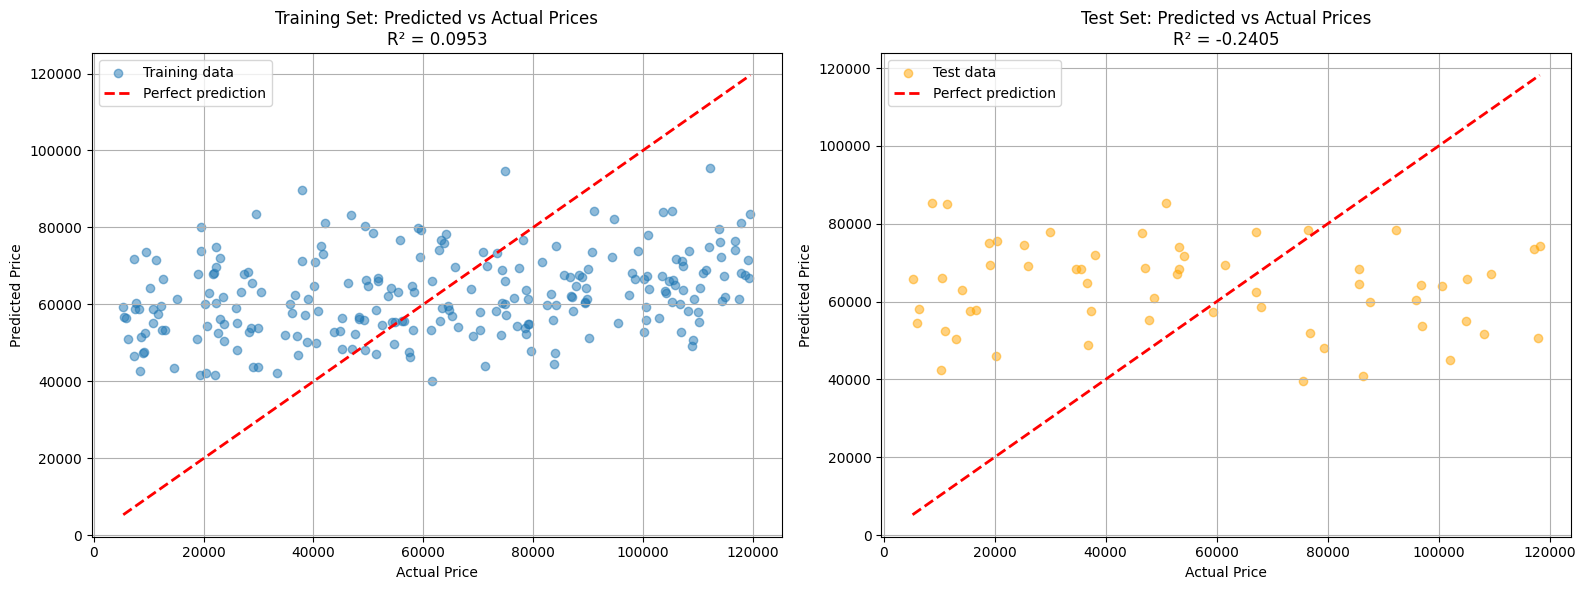

In [64]:
# Visualization: Predicted vs Actual for both Train and Test sets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Training set
ax1.scatter(y_actual_train, y_pred_train, alpha=0.5, label='Training data')
ax1.plot([y_actual_train.min(), y_actual_train.max()], 
         [y_actual_train.min(), y_actual_train.max()], 
         'r--', linewidth=2, label='Perfect prediction')
ax1.set_xlabel('Actual Price')
ax1.set_ylabel('Predicted Price')
ax1.set_title(f'Training Set: Predicted vs Actual Prices\nR² = {r_squared_train:.4f}')
ax1.grid(True)
ax1.legend()

# Test set
ax2.scatter(y_actual_test, y_pred_test, alpha=0.5, color='orange', label='Test data')
ax2.plot([y_actual_test.min(), y_actual_test.max()], 
         [y_actual_test.min(), y_actual_test.max()], 
         'r--', linewidth=2, label='Perfect prediction')
ax2.set_xlabel('Actual Price')
ax2.set_ylabel('Predicted Price')
ax2.set_title(f'Test Set: Predicted vs Actual Prices\nR² = {r_squared_test:.4f}')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()